# Trees and Forests

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.ensemble import RandomForestRegressor

In [2]:
Housing = pd.read_csv('ahs_clean.zip', compression='zip')
y = Housing['LOGVALUE']
Housing['LOGSQFT'] = np.log(Housing['UNITSF'])
Housing['LOGLOT'] = np.log(Housing['LOT'])
Housing.head()

,LOGVALUE,LOT,UNITSF,CLIMB,DIRAC,NUMAIR,BUSPER,EXCLUS,HOWH,NUMCOLD,...,ZADEQ,EROACH,EVROD,CRACKS,HOLES,NOWIRE,AGE,WHN,LOGSQFT,LOGLOT
0,0.693147,900.0,2314.179989,2.011952,1.51928,1.730885,0.0,0.0,6.0,1.828194,...,1,2,2,2,2,1,91,41,7.746811,6.802395
1,0.693147,14520.0,2500.000000,2.011952,1.51928,1.730885,0.0,0.0,10.0,1.828194,...,1,2,2,2,2,1,2,2,7.824046,9.583282
2,0.693147,11000.0,7507.000000,2.011952,1.51928,1.000000,0.0,0.0,9.0,1.828194,...,1,2,2,2,2,1,26,18,8.923591,9.305651
3,1.609438,23760.0,830.000000,2.011952,1.51928,1.000000,0.0,0.0,10.0,1.828194,...,1,2,1,2,2,1,36,15,6.721426,10.075759
4,1.609438,3000.0,1100.000000,2.011952,1.51928,4.000000,0.0,0.0,7.0,1.828194,...,1,2,2,1,2,1,26,4,7.003065,8.006368


In [3]:
Xvars1 = ['LOGLOT','LOGSQFT','BEDRMS','BATHS']
Xvars2 = Xvars1 + ['REGION','METRO','KITCHEN','DISH', 'WASH','DRY','COOK','DENS','DINING', 
                   'FAMRM','HALFB','LIVING','OTHFN', 'RECRM','PORCH','SINK','LAUNDY', 
                   'FLOORS','CONDO','ROOMS','PLUMB', 'NOWIRE','AGE']
Xvars3 = Xvars2 + [n for n in Housing.columns if n.startswith('ROACH') | n.startswith('RATS') | n.startswith('WATER') | n.startswith('CELLAR') | n.startswith('NUM') | n.startswith('FREEZE')]
X3 = Housing[Xvars3]

# Decision Tree (CART)
First we will use a [DecisionTree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html).

In [37]:
def reprune_dt(dt, alpha):
    dt.ccp_alpha=alpha
    dt._prune_tree()
    
def CART_CV(X, y, cv=5, fast=True, min_samples_split=20, min_samples_leaf=7):
    #https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py
    #^^ odly doesn't do K-fold and is slow
    dt = sklearn.tree.DecisionTreeRegressor(random_state=0, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    ccp_alphas = dt.cost_complexity_pruning_path(X, y).ccp_alphas #from low to high

    if fast:
        kf = sklearn.model_selection.KFold(n_splits=cv)
        scores_cv = np.empty((cv,len(ccp_alphas)))
        for f, (train, test) in enumerate(kf.split(X)):
            X_train, y_train = X[train,:], y[train] 
            X_test , y_test  = X[test ,:], y[test] 
            dt = sklearn.tree.DecisionTreeRegressor(random_state=0, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf).fit(X_train, y_train)
            for alpha_i, alpha in enumerate(ccp_alphas):
                reprune_dt(dt, alpha)
                scores_cv[f, alpha_i] = -np.square(dt.predict(X_test) - y_test).mean()
            
        scores = scores_cv.mean(axis=0)
    else:
        scores = np.empty(len(ccp_alphas))
        for alpha_i, ccp_alpha in enumerate(ccp_alphas):
            score = sklearn.model_selection.cross_val_score(sklearn.tree.DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf), X, y, scoring='neg_mean_squared_error')
            scores[alpha_i] = score
        
    alpha_best = ccp_alphas[np.argmax(scores)]
    
    dt = sklearn.tree.DecisionTreeRegressor(random_state=0, ccp_alpha=alpha_best, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf).fit(X, y)
    return([dt, scores, ccp_alphs])

from datetime import datetime
print(datetime.now())
dt_best, scores, ccp_alphas = CART_CV(X3.to_numpy(), y.to_numpy())
print(datetime.now())

2021-09-17 13:48:55.447657
2021-09-17 13:51:00.891220


print(scores.shape, np.argmax(scores))
plt.plot(range(len(scores)), -scores)

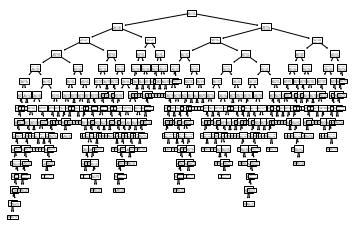

In [38]:
plt.figure()
sklearn.tree.plot_tree(dt_best)
plt.show()

#print(sklearn.tree.export_text(dt_best))

#leaves  = dt_best.apply(X3.to_numpy())
#dt_val, dt_counts = np.unique(leaves, return_counts=True)
#print(np.asarray((dt_val, dt_counts)).T)

# Random Forest
Next we will use a [RandomForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

In [47]:
print(datetime.now())
rf = RandomForestRegressor(n_estimators=100, min_samples_split=20, min_samples_leaf=7).fit(X, y)
print(datetime.now())

2021-09-17 21:15:05.775465
2021-09-17 21:15:47.533624
